Function fitting (Kernel Ridge Regression) : molecular solubility
====

This computer project introduces Kernel Ridge Regression (also known as Gaussian process regression) for fitting 
functions in many dimensions. The concrete application is to make a model of the solubility of small organic
molecules as a function of their molecular structure. 

The number of different organic molecules is enormous, even just considering the small ones. There is an [online database](https://gdb.unibe.ch/downloads) 
of all possible organic molecules made from various number of heavy (non-hydrogen) atoms.
The number of possibilities is enormous, here is a fun fact: you can make nearly [1 billion different shapes from 
6 LEGO bricks](https://brickset.com/article/30827/review-624210-lego-house-6-bricks). One of them is shown below
(printed on a visitor card at the end of a tour, each one unique). Organic molecules are bit similar: you can branch the carbon framework and hang 
off three other elements (H,O,N) or more (if you include halides like Cl and F, or second row elements like P and S).

<img src="lego_6_bricks_card.jpg" width=300>

Function fitting
---

We start by fitting a simple one variable function using a variety of ways.

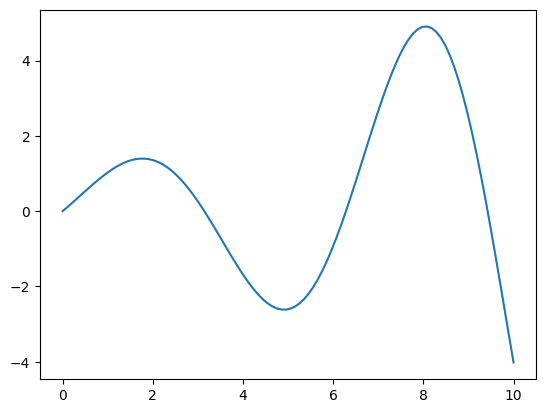

In [151]:
import numpy as np
from matplotlib.pyplot import *
# target function
def f(x):
    return np.sin(x)*np.exp(x/5)

x_values = np.linspace(0,10, 100)
y_values = f(x_values)

plot(x_values, y_values)

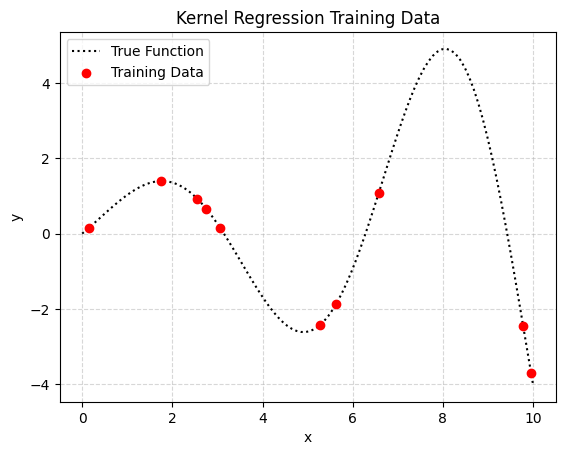

In [152]:
# gather some data points which we will fit to
import random
import matplotlib.pyplot as plt

n = 10 # number of points

random.seed(42069)
x_train = np.random.random(n)*n
y_train = f(x_train)

# Plot ground truth function

plot(x_values, y_values, ':', label="True Function", color='black')
# Plot training data
plt.scatter(x_train, y_train, color='red', label="Training Data", zorder=3)

# Labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression Training Data")

# Legend
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

In [153]:
# define a Gaussian kernel
sig = 1.0 # length scale
def kernel(x1, x2, sig):
    return np.exp(-(x1-x2)**2/(2*sig**2))

K = np.zeros((n,n))
# Now apply the formulas from the lecture to fill in the kernel matrix and 
# compute fitting coefficients. Use the function numpy.linalg.lstsq() to solve the linear problem K@c=y
# (look up its documentation, and don't forget that it returns 4 things, but you only need the solution vector)

lam = 0.1 # strength of regulariser

# now use your coefficients to predict the function on the xx array
# y = sum over n points of the c power of the kernel 

# construct the K matrix
K = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        K[i,j] = kernel(x_train[i], x_train[j], sig)


# Construct the K_s matrix
K_s = np.zeros((len(x_values), len(x_train)))
for i in range(len(x_values)):
    for j in range(len(x_train)):
        K_s[i,j] = kernel(x_values[i], x_train[j], sig)


# Find the (regularised) c vector
c_reg, _, _, _ = np.linalg.lstsq(K + lam * np.eye(n), y_train, rcond=None)  # Regularized K


y_pred = K_s @ c_reg




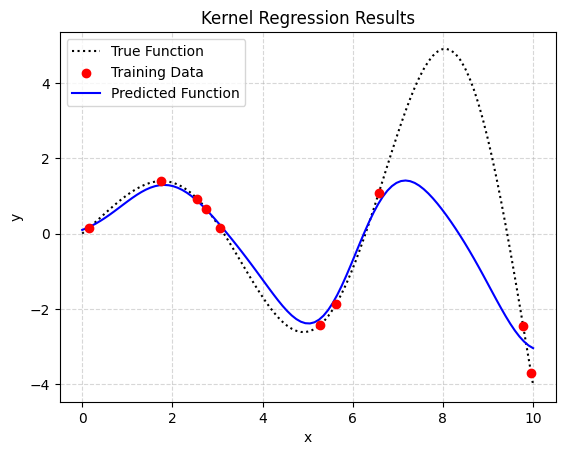

In [154]:
import matplotlib.pyplot as plt 

# Plot ground truth function
plt.plot(x_values, y_values, ':', label="True Function", color='black')

# Plot training data
plt.scatter(x_train, y_train, color='red', label="Training Data", zorder=3)

# Plot predicted function
plt.plot(x_values, y_pred, label="Predicted Function", color='blue')

# Labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression Results")

# Legend
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


Task 1
--

Using now explore the predictions by varying
- the lengthscale sig between 0.1 and 10,
- the regularisation strength lam between 0.001 and 2, 
- the number of data points between 1 and 20

Give a summary of your findings, including the interplay between the above parameters!

Hence, we have clarified that our function returns the _exact_ same function as the script for task 1. We may proceed.

To answer the question above, we should
- run a hyperparameter sweep over the above hyperparameters
- plot lengthscale v regularisation strength
- plot the interplay for different data points

So we have a set number of 
- x_values: np.linspace(0,10, 100)
- y_values: f(xx)
- x_train: inducing points 
So we can think of xx and yy as our 'ground truth' function.

We have to go through our approximation and test three different parameters:
- number of points we are using for interpolation
- lengthscale ($\sigma$)
- regularisation ($\lambda$)


Lets set up a function using our code above to easily run *kernel ridge regression*.

In [98]:
# We will make our function as general as possible to try and scaffold as much understanding as possible
# when, later, we are worried about computational efficiency, we will perform less in this loop, factoring out as much as possible

def kernel_ridge_regression(x_values, y_values, n_inducing_points, sig, lam, func, x_train, use_x_train):

    x_values = x_values # this is our full dataset

    n_points = len(x_values) # number of samples in our dataset

    y_values = func(x_values) # this is our dependent variable - what we are trying to predict

    if use_x_train == False:

        x_train = np.random.choice(x_values, n_inducing_points, replace=False) # getting our x_train

    else:

        n_inducing_points = len(x_train)

    y_train = func(x_train) # setting our y_train values


    # Training Kernel
    K = np.zeros((n_inducing_points,n_inducing_points))

    for i in range(n_inducing_points):
        for j in range(n_inducing_points):
            K[i,j] = kernel(x_train[i], x_train[j], sig) # kernel func between training points

    # Cross-kernel
    K_s= np.zeros((n_points, n_inducing_points))

    for i in range(n_points):
        for j in range(n_inducing_points):
            K_s[i,j] = kernel(x_values[i], x_train[j], sig) # kernel between data and training points

    c, _, _, _ = np.linalg.lstsq(K + lam * np.eye(n_inducing_points), y_train, rcond=None)  # Regularized K

    y_pred = K_s @ c

    return y_pred, x_train

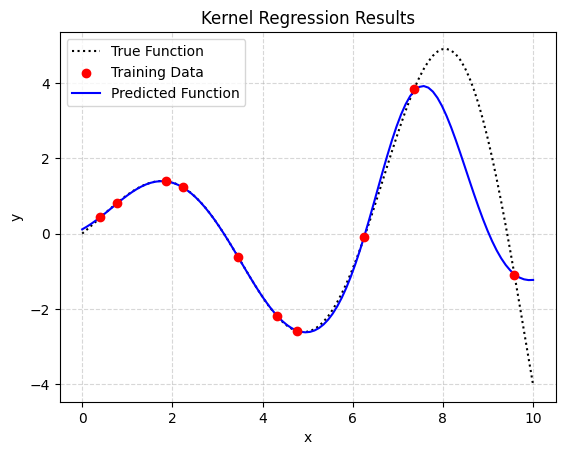

In [155]:
# Testing our function to see if it works the same as previously 

# Plot ground truth function
plt.plot(x_values, y_values, ':', label="True Function", color='black')

x_train = np.random.random(n)*n

y_pred, x_train = kernel_ridge_regression(x_values, y_values, 10, 1, 0.01, f, x_train, use_x_train=True)

# Plot training data
plt.scatter(x_train, f(x_train), color='red', label="Training Data", zorder=3)


# Plot predicted function
plt.plot(x_values, y_pred, label="Predicted Function", color='blue')

# Labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression Results")

# Legend
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

In [143]:
import itertools as tools
import pandas as pd 

# Define new parameter ranges
sig_values = [0.1, 0.5, 1, 2, 5, 10]  # Lengthscale
lam_values = [0.001, 0.01, 0.1, 1, 2]  # Regularization strength
n_values = [1, 2, 5, 10, 15, 20]  # Number of training points

# Full dataset
x_values = np.linspace(0, 10, 100)
y_values = f(x_values)

# Initialize list to store results before creating DataFrame
results_list = []

# Loop through hyperparameter combinations
for n in n_values:

    x_train = np.random.random(n) * 10  # Setting same points for each hyperparam loop  

    for sig in sig_values:
        for lam in lam_values:

            y_pred, x_train = kernel_ridge_regression(x_values, y_values, n, sig, lam, f, x_train, True)

            mse = np.mean((y_pred - y_values) ** 2)  # MSE
            rmse = np.sqrt(mse)  # RMSE

            # Append results to list
            results_list.append({
                'Lengthscale (σ)': sig,
                'Regularization (λ)': lam,
                'Num Points (n)': n,
                'Predictions (y_pred)': y_pred,  # Storing the entire prediction vector
                'MSE': mse,
                'RMSE': rmse,
                'x_train': x_train
            })

# Convert list to DataFrame
results = pd.DataFrame(results_list)


In [144]:
from IPython.display import display

# Convert list to DataFrame
results = pd.DataFrame(results_list)

# Display the results DataFrame
display(results)  # Works in Jupyter Notebook

# If using a script, you can also print a preview
print(results.head())  # Shows first 5 rows

,Lengthscale (σ),Regularization (λ),Num Points (n),Predictions (y_pred),MSE,RMSE,x_train
0,0.1,0.001,1,"[1.609641140740646e-113, 9.69684520126974e-104...",5.385280,2.320621,[2.2798915125697086]
1,0.1,0.010,1,"[1.5952978038429573e-113, 9.610437669773276e-1...",5.385464,2.320660,[2.2798915125697086]
2,0.1,0.100,1,"[1.464773438073988e-113, 8.824129133155462e-10...",5.387321,2.321060,[2.2798915125697086]
3,0.1,1.000,1,"[8.056253909406933e-114, 4.853271023235504e-10...",5.401741,2.324165,[2.2798915125697086]
4,0.1,2.000,1,"[5.370835939604622e-114, 3.235514015490336e-10...",5.410031,2.325947,[2.2798915125697086]
...,...,...,...,...,...,...,...
175,10.0,0.001,20,"[1.3224924769911013, 1.217787578450043, 1.1160...",4.049643,2.012372,"[7.457689640776795, 3.0277125291763207, 6.8441..."
176,10.0,0.010,20,"[0.8660672984700568, 0.8134995954298461, 0.762...",4.460844,2.112071,"[7.457689640776795, 3.0277125291763207, 6.8441..."
177,10.0,0.100,20,"[0.35835717563992375, 0.34706805073176383, 0.3...",4.675746,2.162347,"[7.457689640776795, 3.0277125291763207, 6.8441..."
178,10.0,1.000,20,"[0.2318806698637621, 0.23736026618592865, 0.24...",4.891312,2.211631,"[7.457689640776795, 3.0277125291763207, 6.8441..."


   Lengthscale (σ)  Regularization (λ)  Num Points (n)  \
0              0.1               0.001               1   
1              0.1               0.010               1   
2              0.1               0.100               1   
3              0.1               1.000               1   
4              0.1               2.000               1   

                                Predictions (y_pred)       MSE      RMSE  \
0  [1.609641140740646e-113, 9.69684520126974e-104...  5.385280  2.320621   
1  [1.5952978038429573e-113, 9.610437669773276e-1...  5.385464  2.320660   
2  [1.464773438073988e-113, 8.824129133155462e-10...  5.387321  2.321060   
3  [8.056253909406933e-114, 4.853271023235504e-10...  5.401741  2.324165   
4  [5.370835939604622e-114, 3.235514015490336e-10...  5.410031  2.325947   

                x_train  
0  [2.2798915125697086]  
1  [2.2798915125697086]  
2  [2.2798915125697086]  
3  [2.2798915125697086]  
4  [2.2798915125697086]  


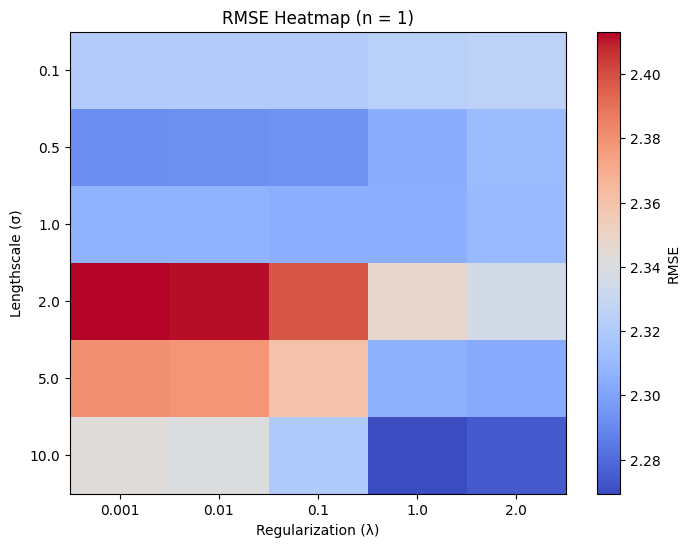

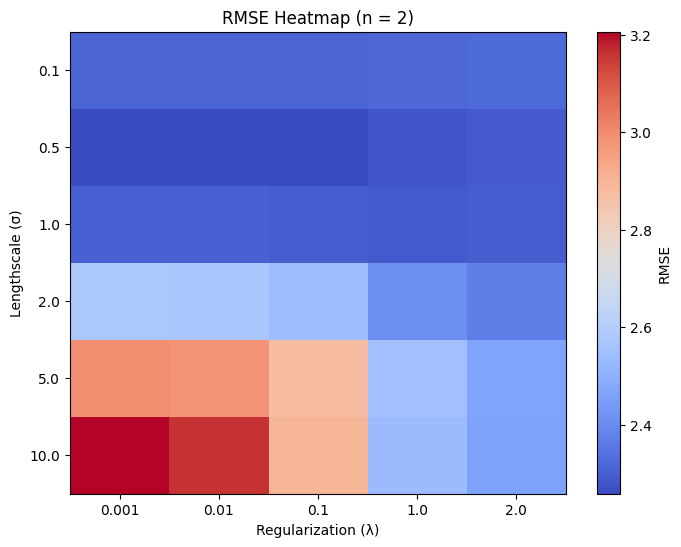

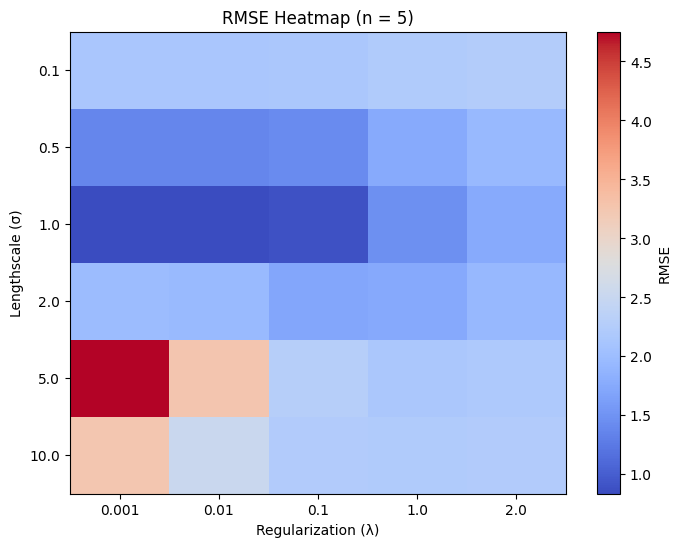

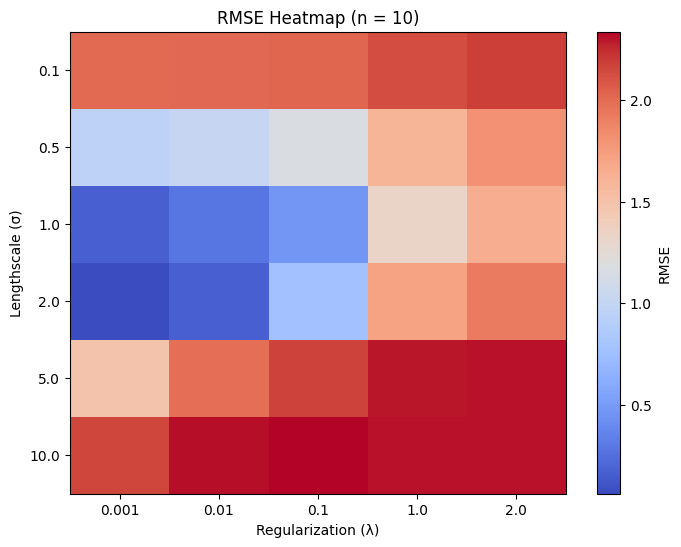

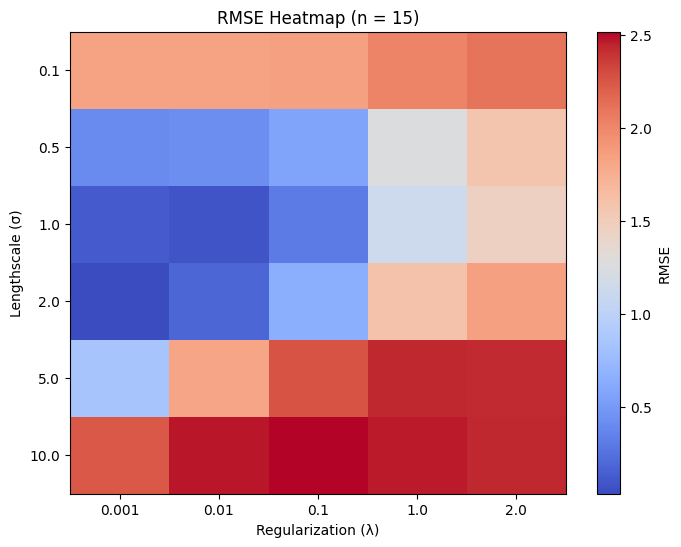

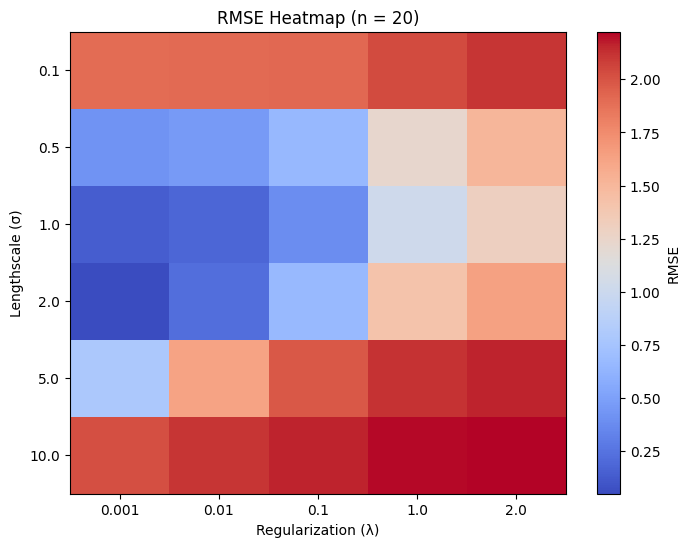

In [145]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique values of n
n_unique = results["Num Points (n)"].unique()

# Create heatmaps for each n
for n in n_unique:
    subset = results[results["Num Points (n)"] == n]

    # Pivot the data into a 2D array
    sig_values = np.sort(subset["Lengthscale (σ)"].unique())
    lam_values = np.sort(subset["Regularization (λ)"].unique())

    mse_matrix = np.zeros((len(sig_values), len(lam_values)))

    for i, sig in enumerate(sig_values):
        for j, lam in enumerate(lam_values):
            mse_matrix[i, j] = subset[(subset["Lengthscale (σ)"] == sig) & 
                                      (subset["Regularization (λ)"] == lam)]["RMSE"].values[0]

    # Create heatmap using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(mse_matrix, cmap="coolwarm", aspect="auto")

    # Labels and ticks
    ax.set_xticks(np.arange(len(lam_values)))
    ax.set_yticks(np.arange(len(sig_values)))
    ax.set_xticklabels(lam_values)
    ax.set_yticklabels(sig_values)
    ax.set_xlabel("Regularization (λ)")
    ax.set_ylabel("Lengthscale (σ)")
    ax.set_title(f"RMSE Heatmap (n = {n})")

    # Colorbar
    fig.colorbar(cax, label="RMSE")

    # Show the heatmap
    plt.show()


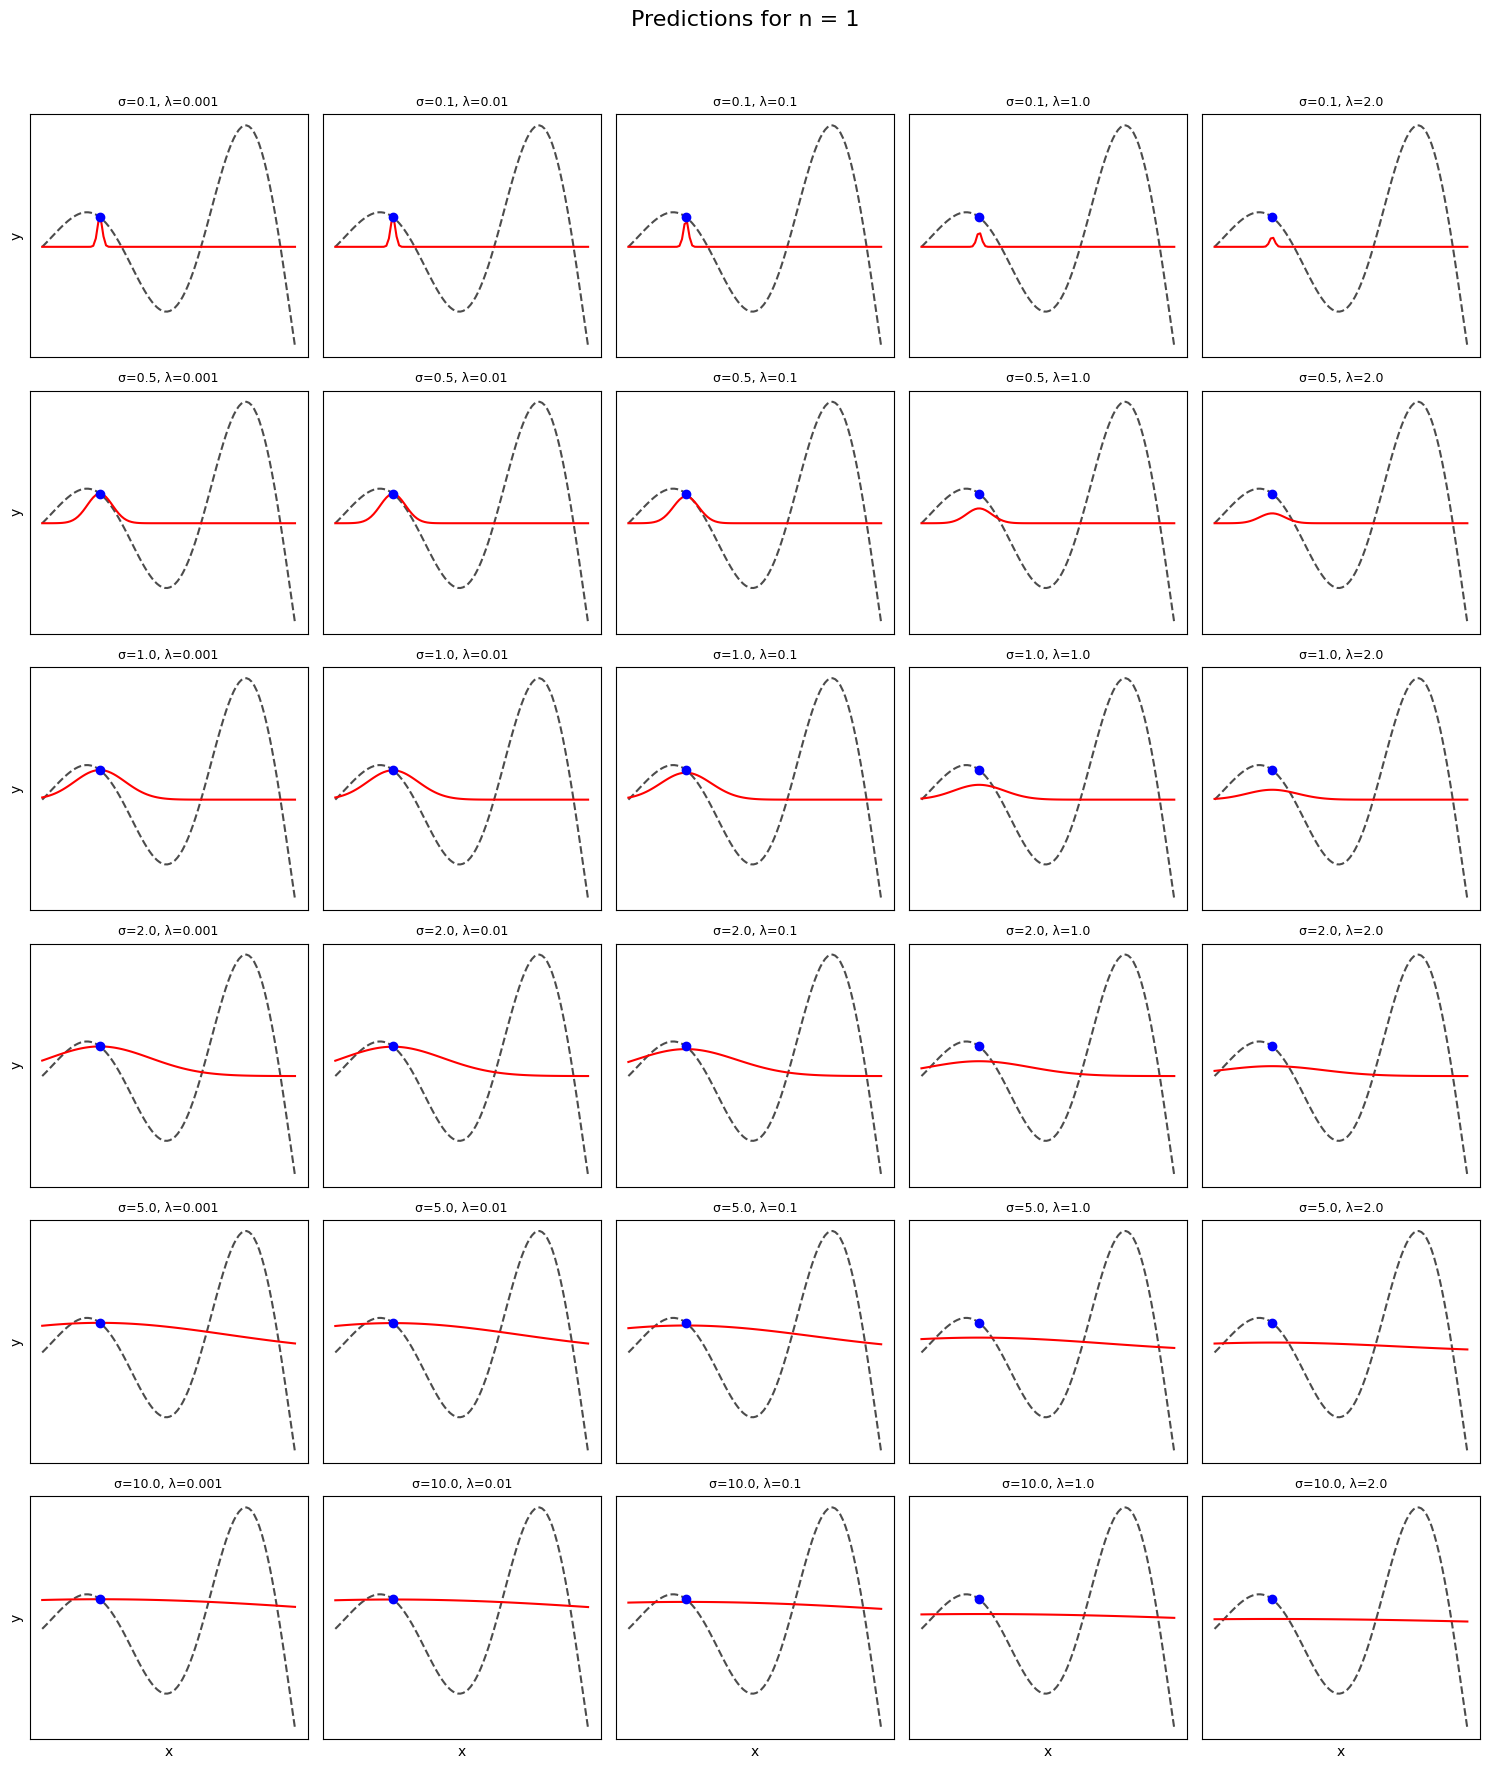

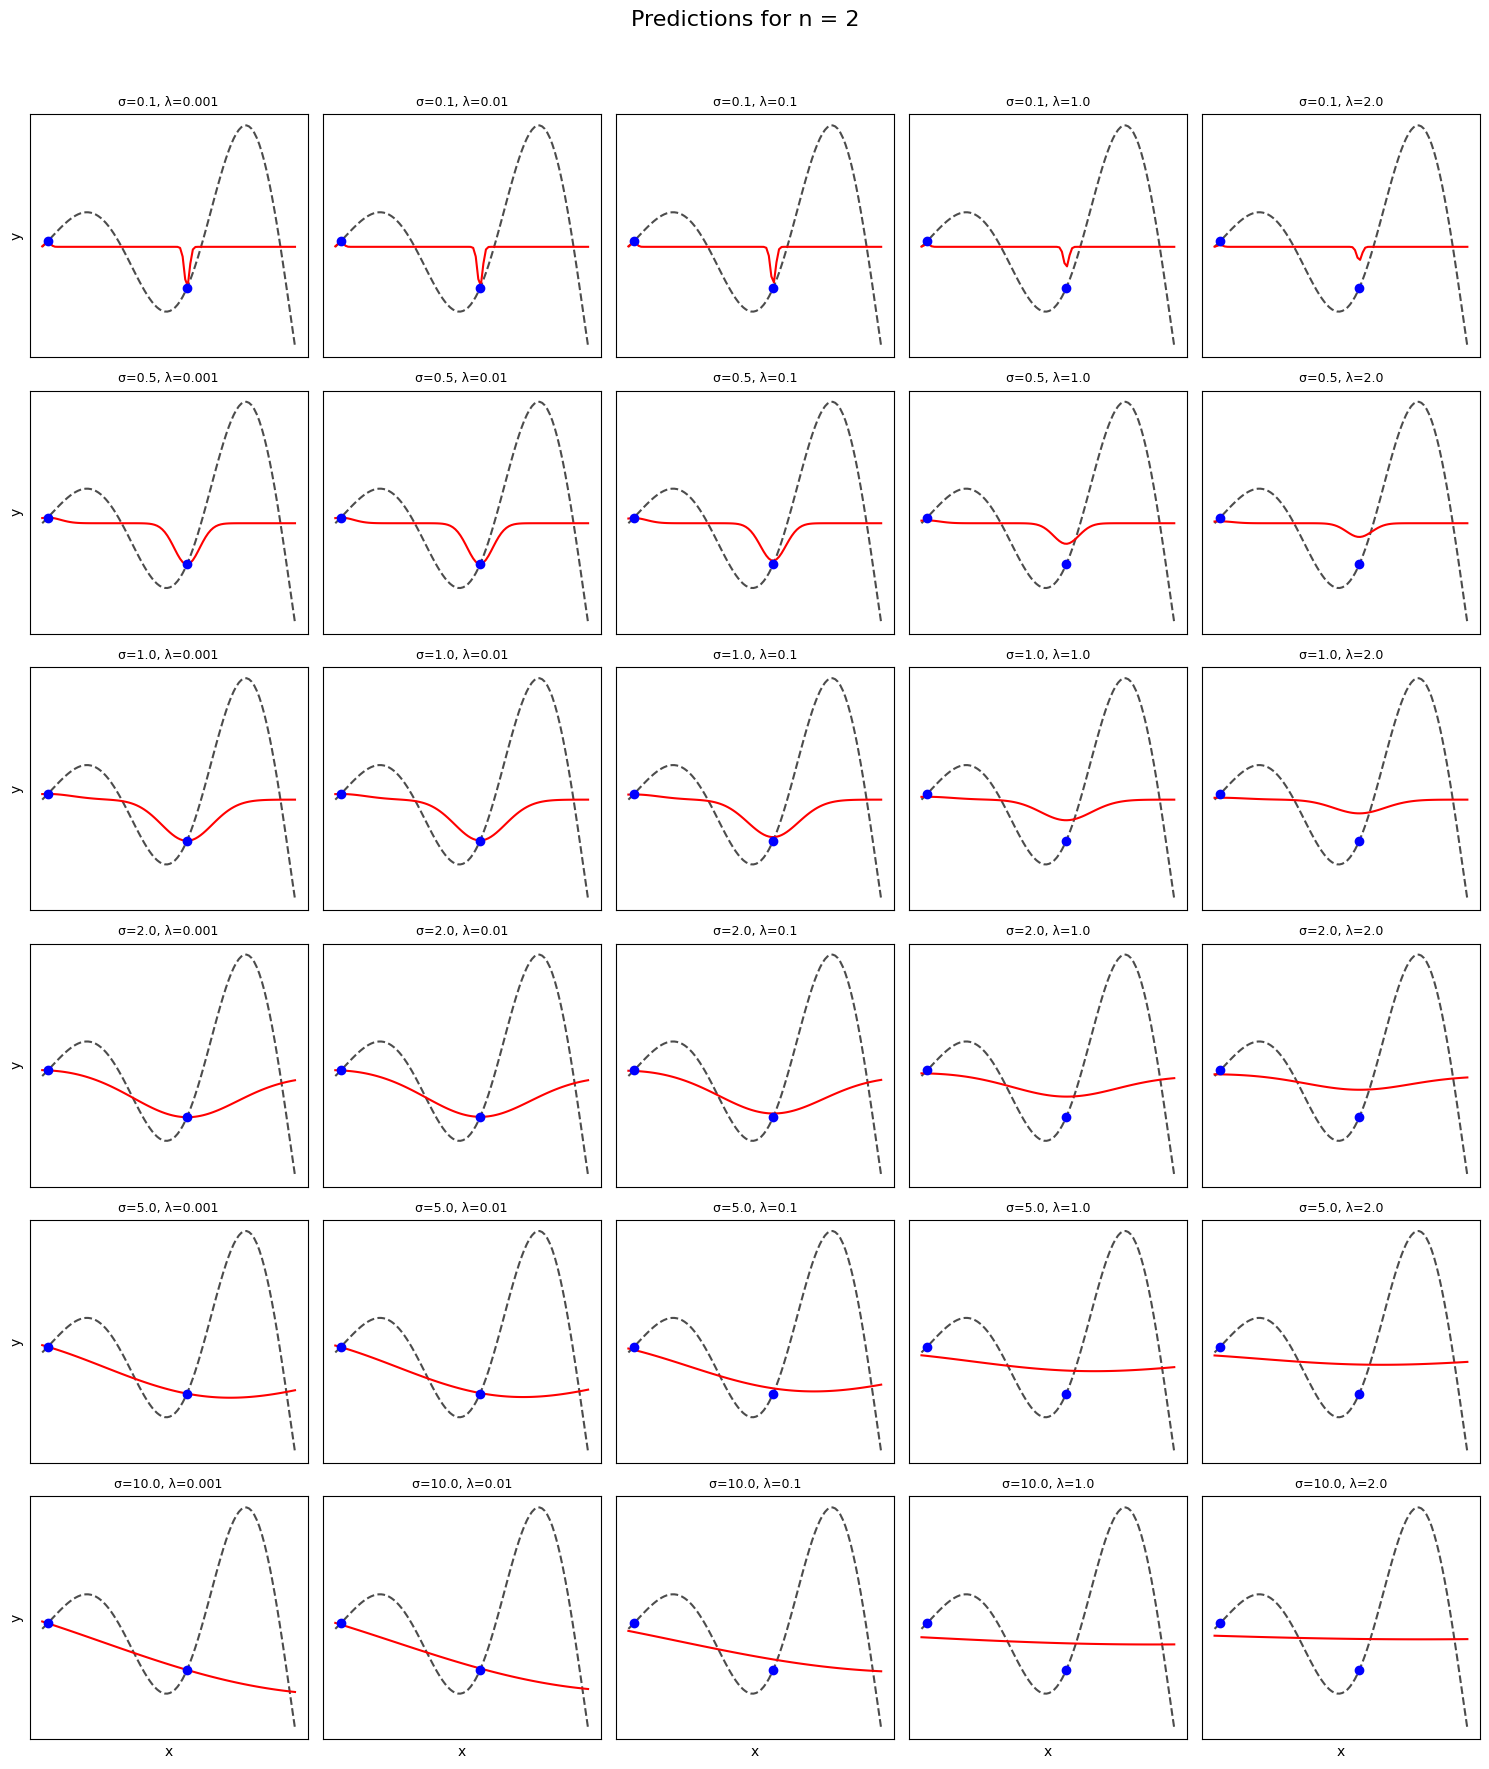

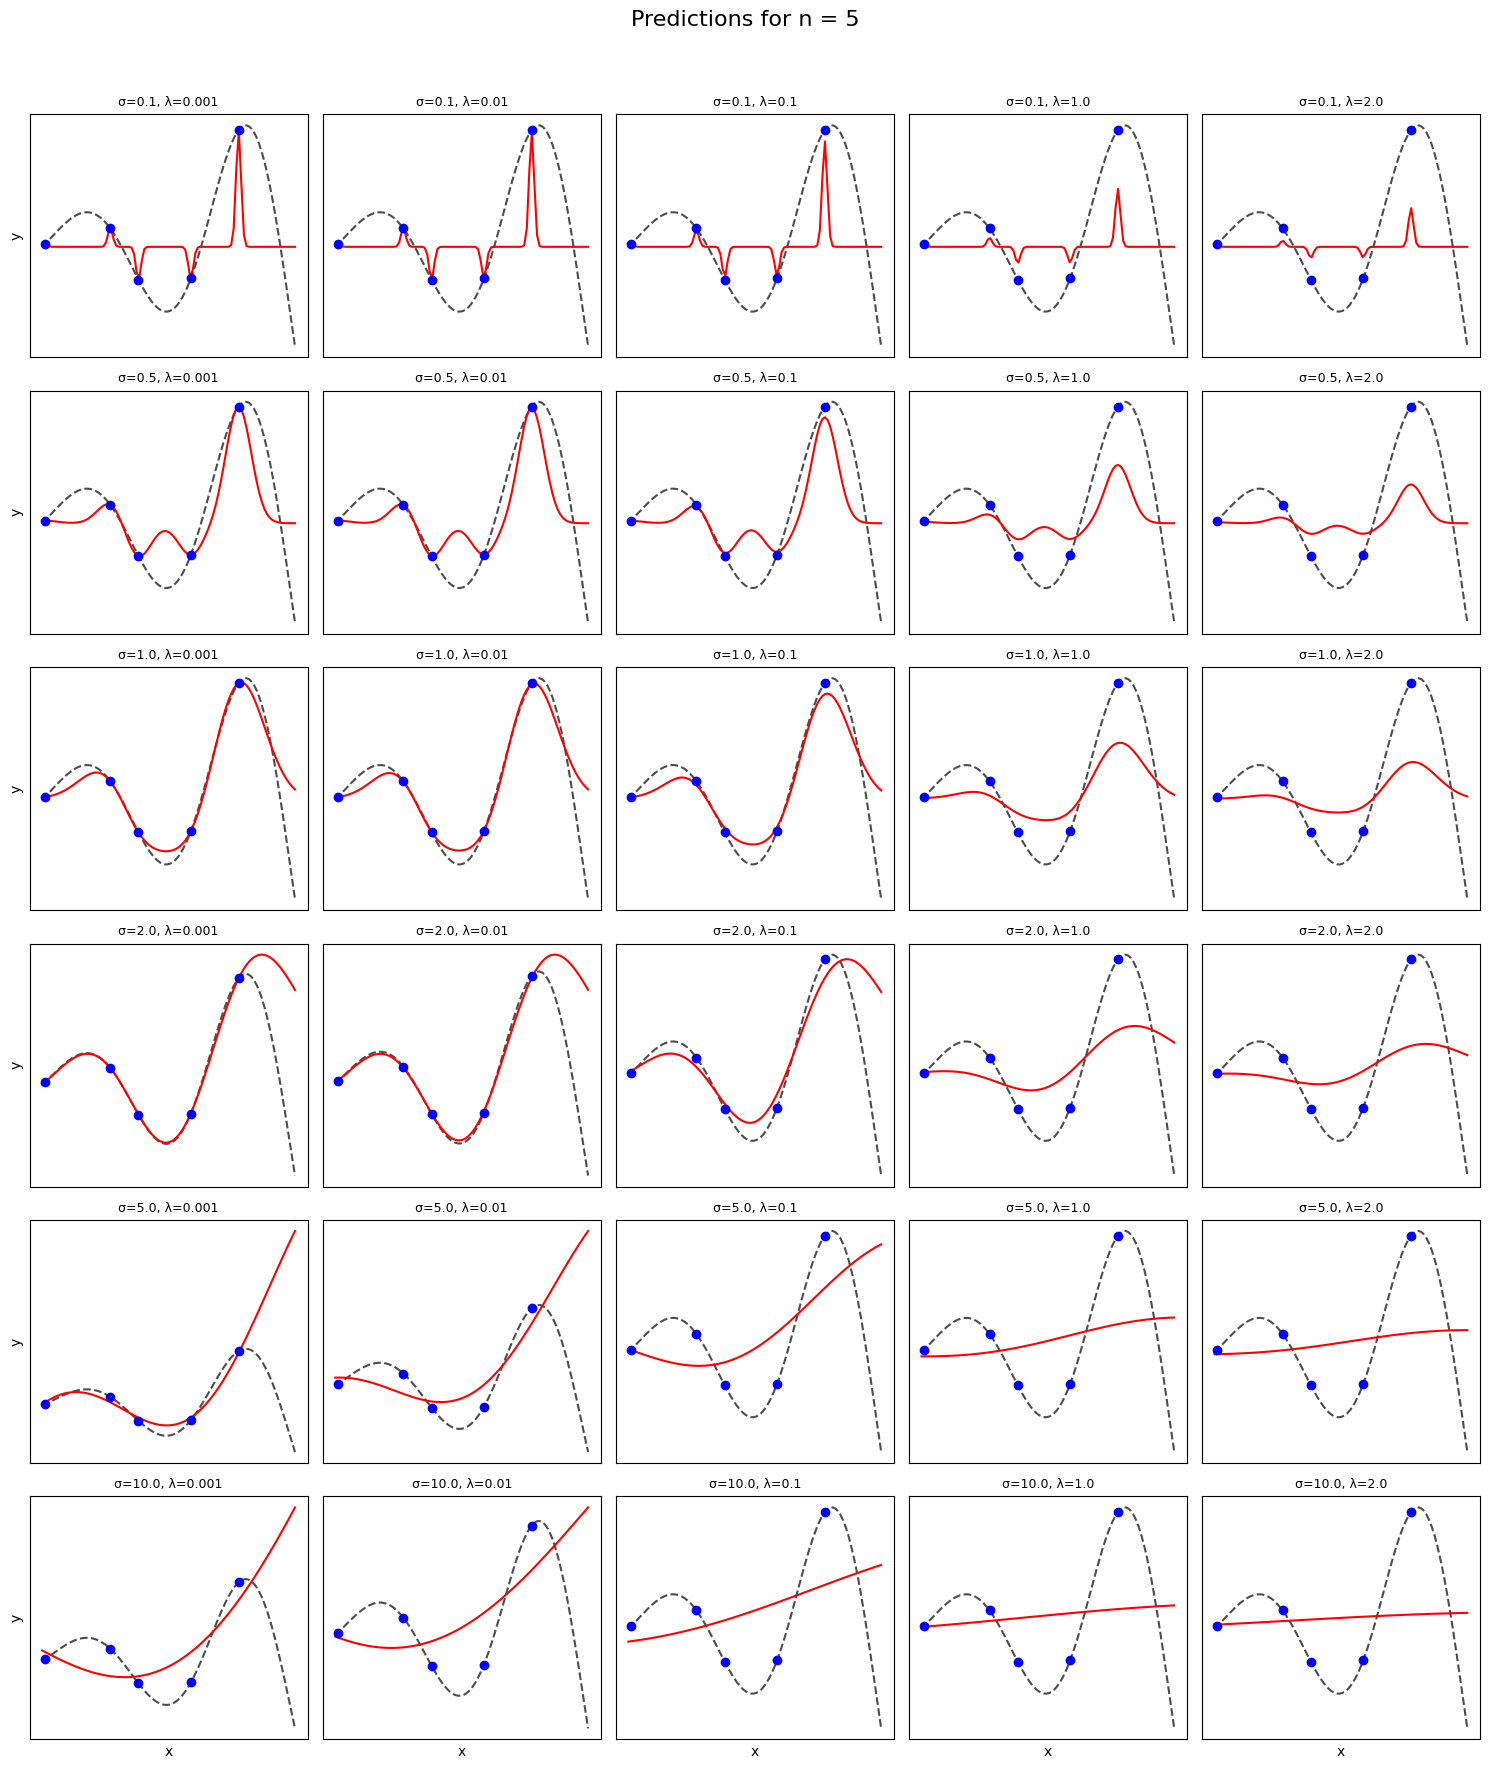

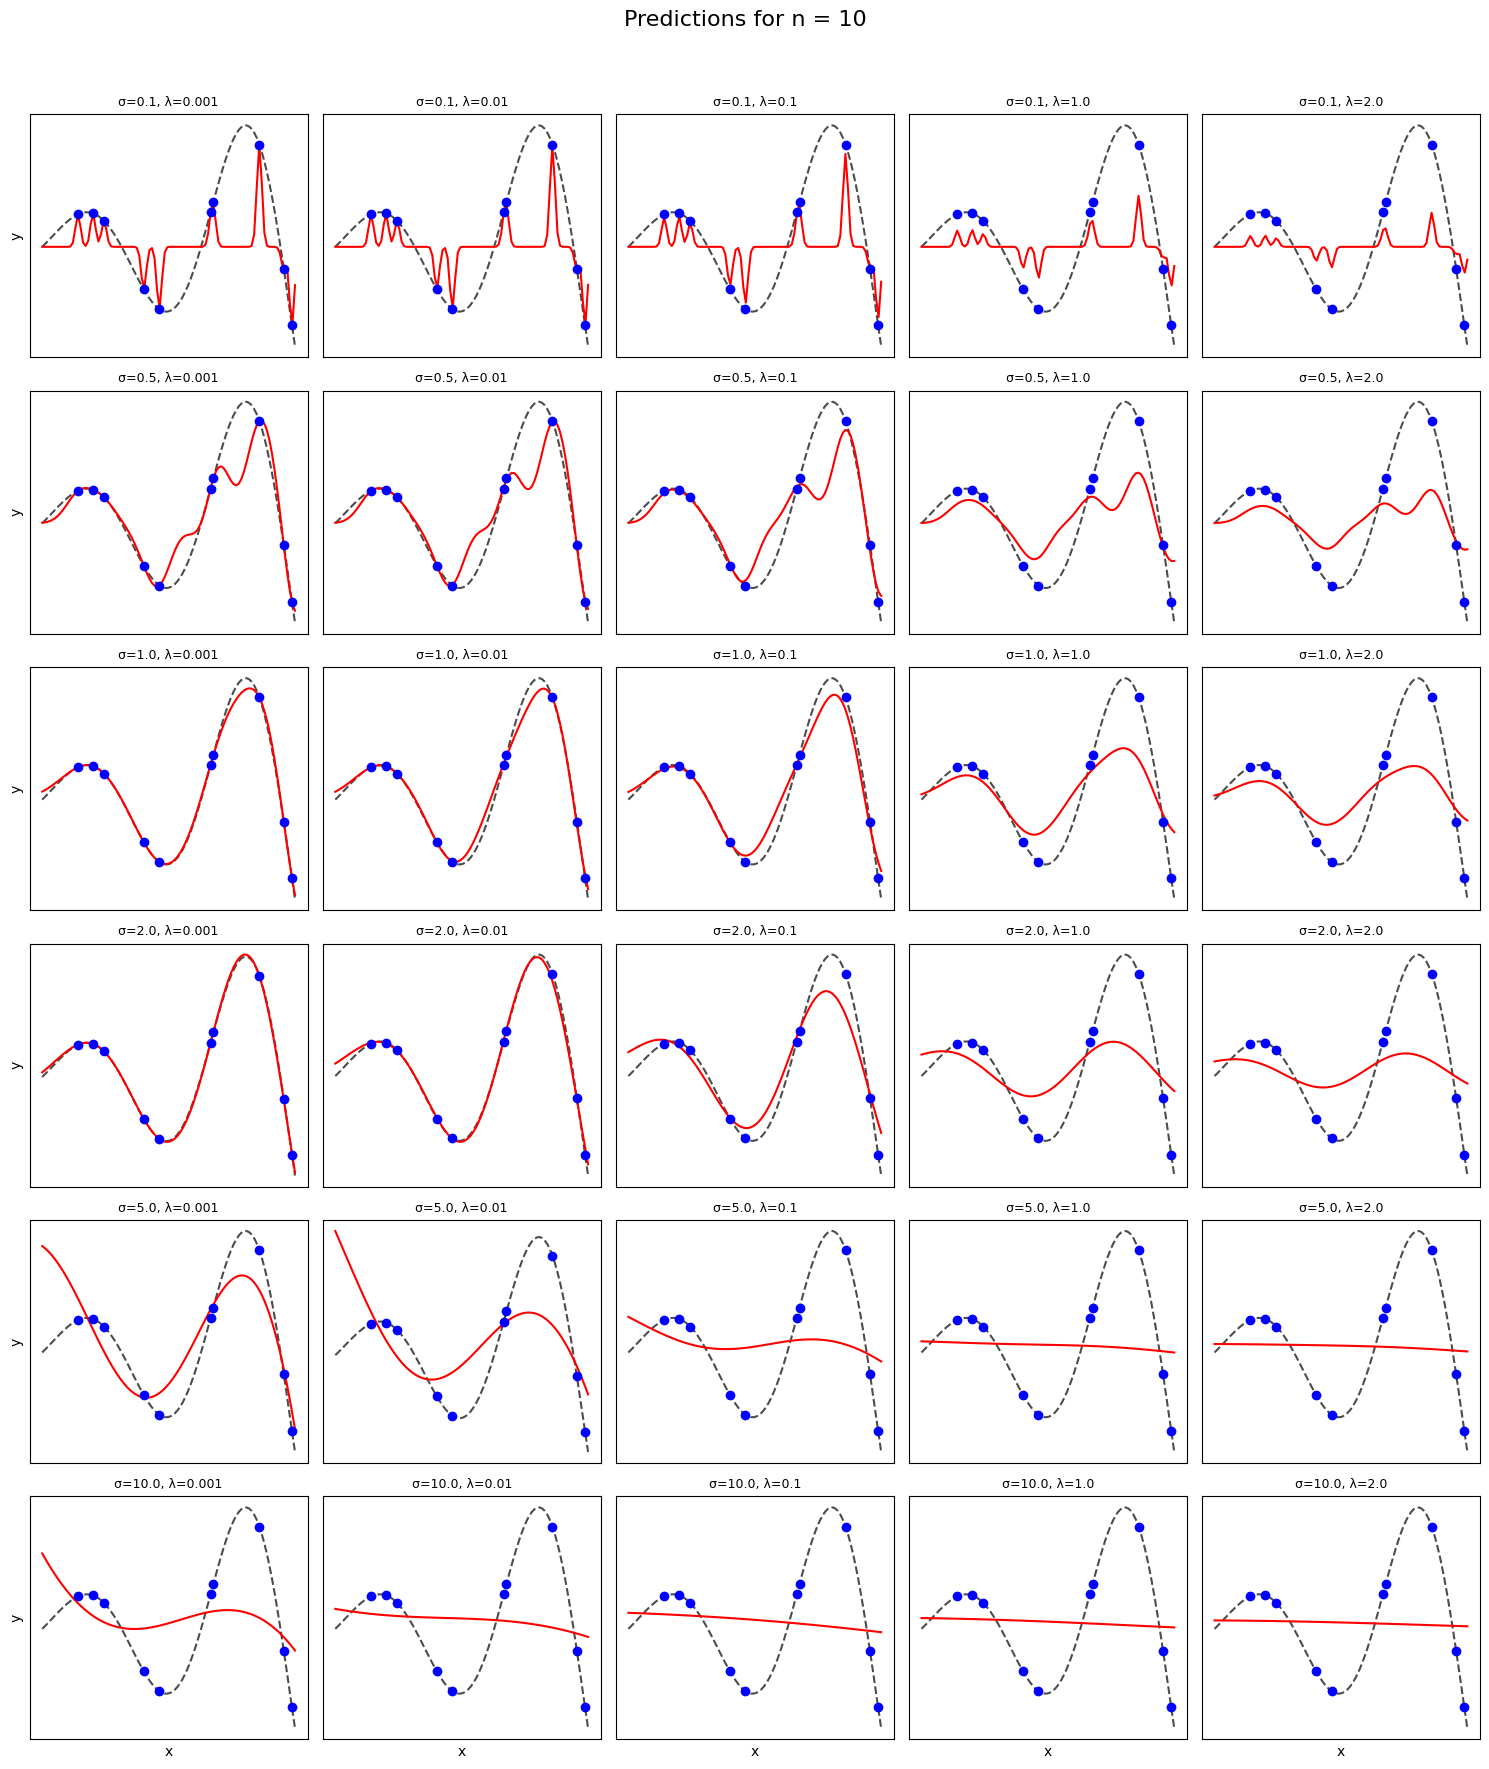

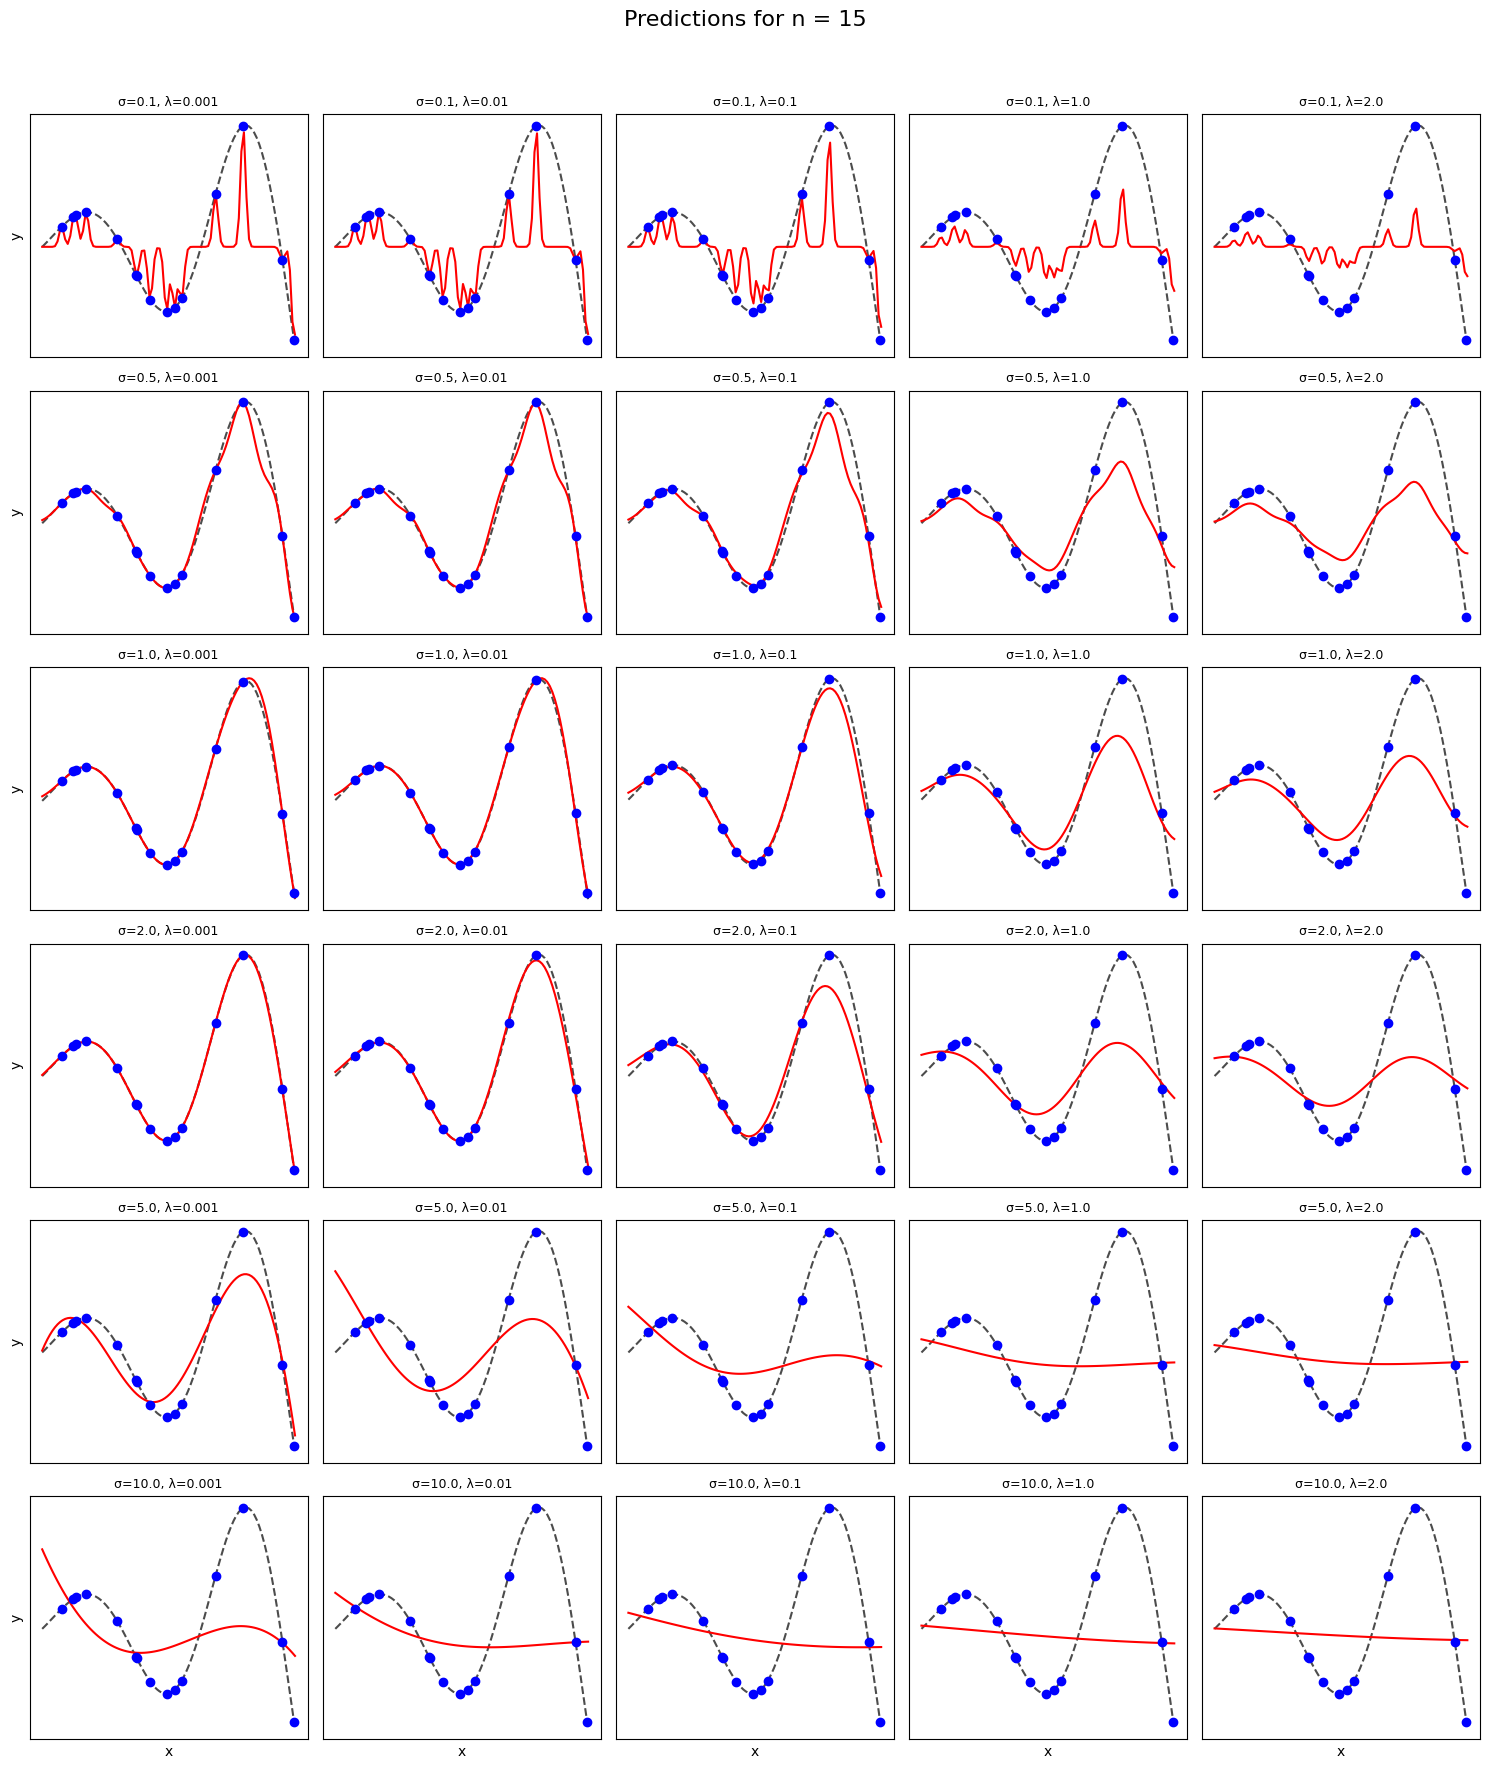

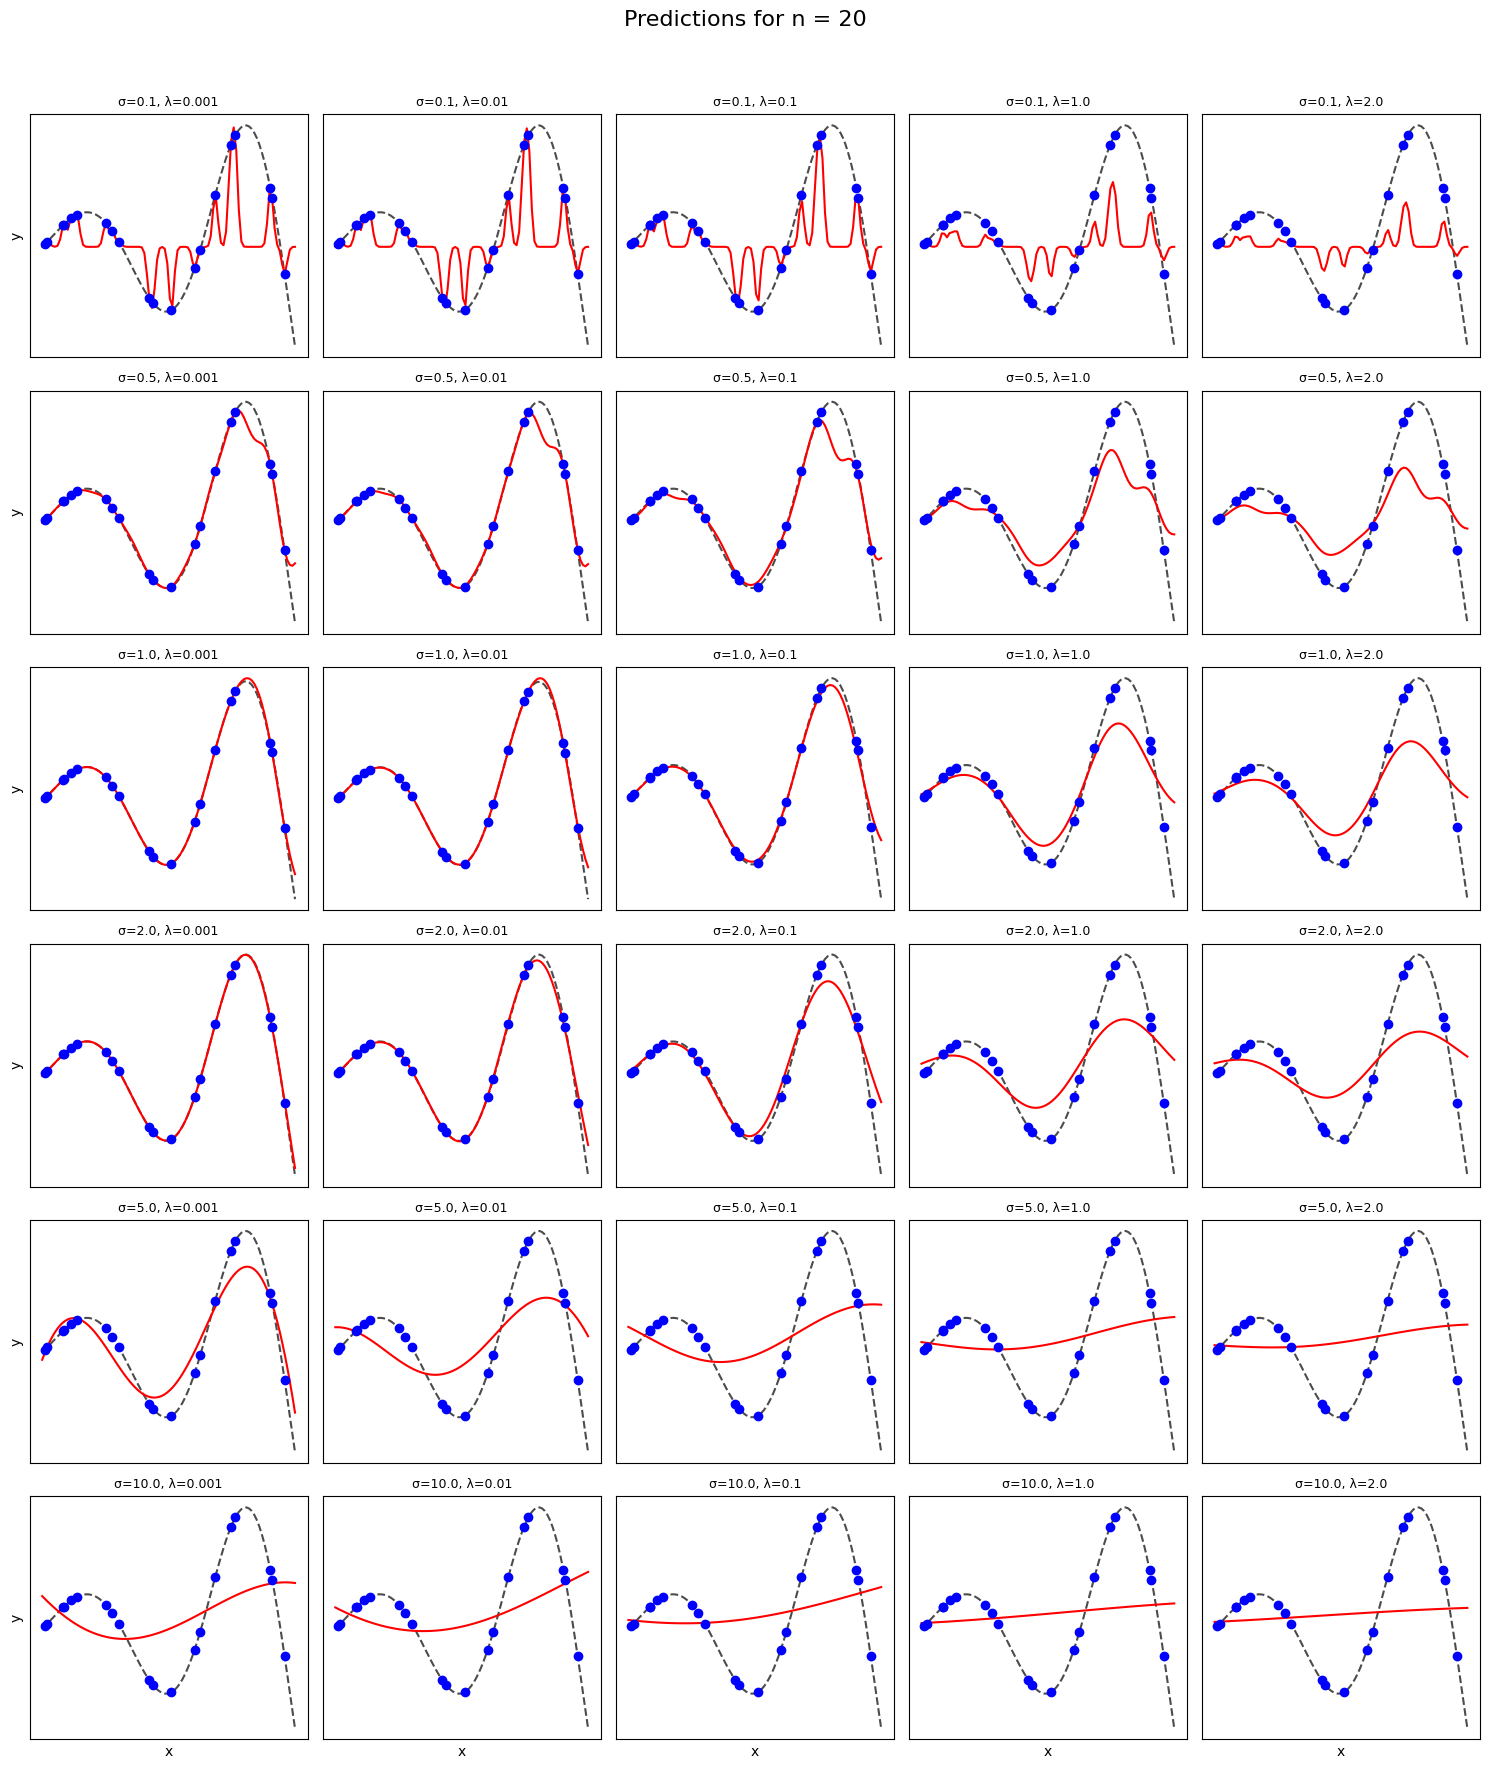

In [146]:
import matplotlib.pyplot as plt

# Unique values of n, sig, and lam
n_unique = results["Num Points (n)"].unique()
sig_values = np.sort(results["Lengthscale (σ)"].unique())
lam_values = np.sort(results["Regularization (λ)"].unique())

# Full dataset (ground truth)
x_values = np.linspace(0, 10, 100)
y_values = f(x_values)  # True function

# Loop through each training data size (n)
for n in n_unique:
    fig, axes = plt.subplots(nrows=len(sig_values), ncols=len(lam_values), figsize=(15, 18))
    fig.suptitle(f"Predictions for n = {n}", fontsize=16)

    for i, sig in enumerate(sig_values):
        for j, lam in enumerate(lam_values):
            # Select the corresponding result
            subset = results[
                (results["Num Points (n)"] == n) &
                (results["Lengthscale (σ)"] == sig) &
                (results["Regularization (λ)"] == lam)
            ]
            
            if not subset.empty:
                y_pred = subset["Predictions (y_pred)"].values[0]  # Extract predictions
                x_train = subset["x_train"].values[0]  # Extract training x-values
                y_train = f(x_train)  # Compute training y-values using the true function
                
                ax = axes[i, j]
                ax.plot(x_values, y_values, label="True Function", color="black", linestyle="dashed", alpha=0.7)
                ax.plot(x_values, y_pred, label="Predicted", color="red")
                ax.scatter(x_train, y_train, color="blue", marker="o", label="Training Points", zorder=3)

                # Titles and labels
                ax.set_title(f"σ={sig}, λ={lam}", fontsize=9)
                ax.set_xticks([])
                ax.set_yticks([])

                # Reduce clutter by only showing some axis labels
                if i == len(sig_values) - 1:
                    ax.set_xlabel("x")
                if j == 0:
                    ax.set_ylabel("y")

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Optional Extension
----

Investigate what happens when you add i.i.d random noise of a certain size to the _data values_ that you
fit to (But still of course plot the original function without noise to compare with, as well as the data points
with noise added).

In [168]:
def kernel_ridge_regression_with_noise(x_values, y_values, n_inducing_points, sig, lam, func, x_train, use_x_train, noise_std):

    x_values = x_values # this is our full dataset

    n_points = len(x_values) # number of samples in our dataset

    y_values = func(x_values) # this is our dependent variable - what we are trying to predict

    if use_x_train == False:

        x_train = np.random.choice(x_values, n_inducing_points, replace=False) # getting our x_train

    else:

        n_inducing_points = len(x_train)

    

    y_train = func(x_train) # setting our y_train values

    y_train_noisy = y_train + np.random.normal(0, noise_std, size=y_train.shape)



    # Training Kernel
    K = np.zeros((n_inducing_points,n_inducing_points))

    for i in range(n_inducing_points):
        for j in range(n_inducing_points):
            K[i,j] = kernel(x_train[i], x_train[j], sig) # kernel func between training points

    # Cross-kernel
    K_s= np.zeros((n_points, n_inducing_points))

    for i in range(n_points):
        for j in range(n_inducing_points):
            K_s[i,j] = kernel(x_values[i], x_train[j], sig) # kernel between data and training points

    c, _, _, _ = np.linalg.lstsq(K + lam * np.eye(n_inducing_points), y_train, rcond=None)  # Regularized K

    y_pred = K_s @ c

    return y_pred, x_train


Now complete this with extra noise investigations!

Molecular solubility dataset
----

The dataset below contains the solubility of nearly 10K molecules. The original data came from here: 

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8<br>
https://www.nature.com/articles/s41597-019-0151-1

In [157]:
import pandas

In [158]:
sol = pandas.read_csv("curated-solubility-dataset.csv")

In [159]:
sol

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.000000,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.000000,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.000000,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.000000,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.000000,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,I-84,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,...,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548e+00,374.236893
9978,I-85,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,...,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922e+00,1148.584975
9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,...,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720e+00,251.049732
9980,I-93,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,...,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333e+00,938.203977


In [160]:
sol.columns

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')

In [125]:
sol['Solubility'][0] # here is how to access a given property, here the solubility of the first molecule

-3.6161271205

(array([  2.,   0.,   0.,   2.,   0.,   4.,   0.,   1.,   3.,   3.,  10.,
         12.,  20.,  37.,  45.,  68.,  90., 110., 122., 148., 155., 140.,
        119., 143., 181., 223., 259., 294., 340., 362., 397., 405., 489.,
        494., 597., 566., 527., 564., 511., 444., 399., 340., 293., 245.,
        284., 255., 224.,  39.,  13.,   3.]),
 array([-1.31719000e+01, -1.28657084e+01, -1.25595167e+01, -1.22533251e+01,
        -1.19471335e+01, -1.16409418e+01, -1.13347502e+01, -1.10285586e+01,
        -1.07223669e+01, -1.04161753e+01, -1.01099837e+01, -9.80379204e+00,
        -9.49760041e+00, -9.19140878e+00, -8.88521715e+00, -8.57902551e+00,
        -8.27283388e+00, -7.96664225e+00, -7.66045062e+00, -7.35425898e+00,
        -7.04806735e+00, -6.74187572e+00, -6.43568409e+00, -6.12949245e+00,
        -5.82330082e+00, -5.51710919e+00, -5.21091756e+00, -4.90472593e+00,
        -4.59853429e+00, -4.29234266e+00, -3.98615103e+00, -3.67995940e+00,
        -3.37376776e+00, -3.06757613e+00, -2.76138

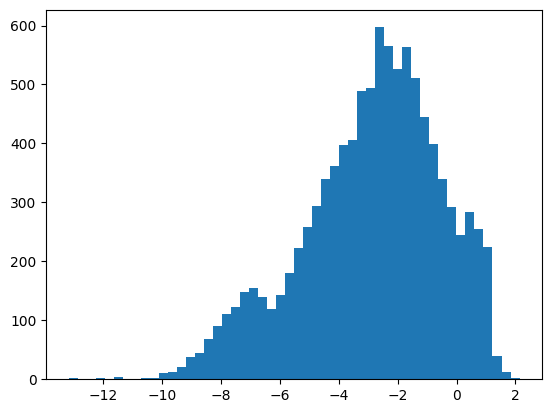

In [161]:
hist(sol['Solubility'], bins=50)

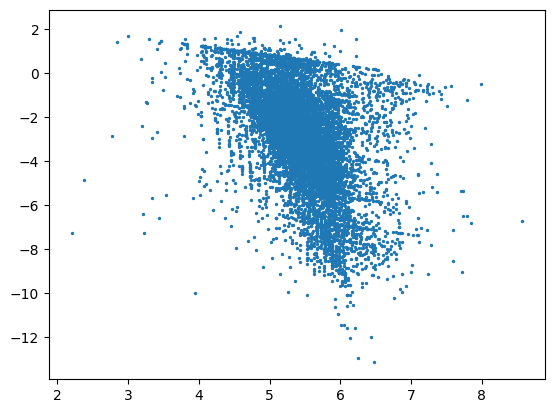

In [127]:
# we can plot the solubility against any given property. Clearly there are relationships, but the solubility is not determined well 
# by any single property. Note how it's better to work with the log of the molecular weight (MolWt)
scatter(np.log(sol['MolWt']), sol['Solubility'], s=2)

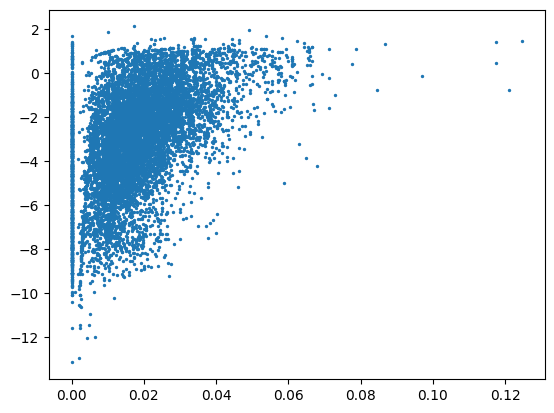

In [128]:
scatter((sol['NumHAcceptors']+sol['NumHDonors'])/sol['MolWt'], sol['Solubility'], s=2)

Linear fit
---

In [162]:
Y = np.array(sol['Solubility']); 

proplist = ['HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount']

X = np.array([list(sol[prop]/sol['MolWt']) for prop in proplist]) # Many properties are extensive, so we divide by the molecular weight
X = np.insert(X, 0, list(np.log(sol['MolWt'])), axis=0) # add the log MolWt as well

In [163]:
X.shape # we have 11 properties

(11, 9982)

In [164]:
c,_,_,_ = np.linalg.lstsq(X.T, Y) # here we fit a LINEAR MODEL , solving the equation  X.T @ c = Y

/var/folders/8m/mlfdjz4d5bd1hd67c6nkhb_00000gn/T/ipykernel_17930/2538874286.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c,_,_,_ = np.linalg.lstsq(X.T, Y) # here we fit a LINEAR MODEL , solving the equation  X.T @ c = Y


In [165]:
c # these are the resulting fitting coefficients

array([ -1.10944433, -30.53332194,  79.21167928,  55.03896321,
        25.21188812, -28.95483872,  11.72036499, -45.36677569,
        42.95943772, -16.12008719, -61.48686288])

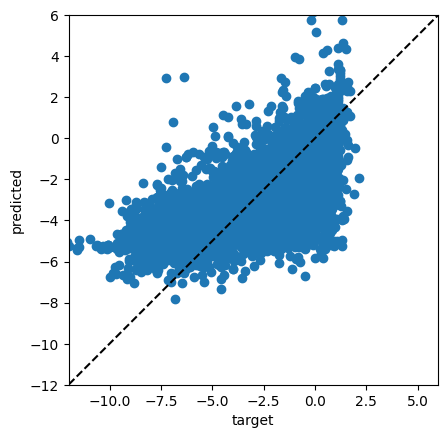

In [166]:
# now we make a scatter plot of target solubility versus predicted solubility
scatter(Y, X.T @ c)
plot([-50,50], [-50,50], 'k--')
xlim(-12,6)
ylim(-12,6)
ylabel('predicted')
xlabel('target')
gca().set_aspect('equal')

In [167]:
# We can calculate the mean squared error of our fit. The solubility values are such that a method with prediction error > 1 is not that useful. 
np.sqrt(sum((Y- X.T @ c)**2)/len(Y))

1.765213071362543

Task 2
---

Now use the Kernel Ridge Regression method to make a kernel fit of the solubility. Your kernel should still be the Gaussian function, but
it operates on vector arguments. You can start with a single sigma, identical for each property, but then choose different lengthscales (sig) in each dimension (a sensible starting value is the standard deviation of the data in each dimension) 

$$
K(x, x') = e^{-\sum_i|x_i-x'_i|^2/(2\sigma_i^2)}
$$

Here $x_i$ refers not to the $i$th data point, but to the $i$th element of the multidimensional data point vector $x$. Optimise the regularisation 
strength to obtain the best fit. You should split your data into a training and test set, and report the prediction error separately. 

In [169]:
import numpy as np

def gaussian_kernel(x1, x2, sig):
    """
    Multidimensional Gaussian Kernel.
    x1, x2: vectors of the same dimension
    sig: vector of lengthscales (one per dimension)
    """
    diff = x1 - x2  # Element-wise difference
    return np.exp(-np.sum((diff ** 2) / (2 * sig ** 2)))  # Apply per-dimension lengthscale

def kernel_ridge_regression_with_noise(x_values, y_values, n_inducing_points, sig, lam, func, x_train, use_x_train, noise_std):
    """
    Kernel Ridge Regression for Multidimensional Data
    """
    # Ensure x_values is 2D (n_samples, n_features)
    x_values = np.array(x_values)
    n_points, dim = x_values.shape  # Number of samples, number of features

    y_values = func(x_values)  # Compute true function values

    # Choose training points
    if not use_x_train:
        idx = np.random.choice(n_points, n_inducing_points, replace=False)  # Random indices
        x_train = x_values[idx]  # Extract training points

    else:
        n_inducing_points = len(x_train)

    y_train = func(x_train)  # Compute function values for training set
    y_train_noisy = y_train + np.random.normal(0, noise_std, size=y_train.shape)  # Add noise

    # Compute Training Kernel Matrix (K)
    K = np.zeros((n_inducing_points, n_inducing_points))
    for i in range(n_inducing_points):
        for j in range(n_inducing_points):
            K[i, j] = gaussian_kernel(x_train[i], x_train[j], sig)  # Apply new kernel

    # Compute Cross Kernel Matrix (K_s)
    K_s = np.zeros((n_points, n_inducing_points))
    for i in range(n_points):
        for j in range(n_inducing_points):
            K_s[i, j] = gaussian_kernel(x_values[i], x_train[j], sig)  # Apply new kernel

    # Solve for coefficients (regularized)
    c, _, _, _ = np.linalg.lstsq(K + lam * np.eye(n_inducing_points), y_train_noisy, rcond=None)

    # Compute predictions
    y_pred = K_s @ c

    return y_pred, x_train


Optional extension
---

You can optimise the $\sigma$ array formally, by minimising an objective function, e.g. the error on a _test set_, or even better,
average error on multiple test sets (given multiple random test/train splits). You can make the regulariser $\lambda$ part of the
optimisation too. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9fbaf274-3ce1-46bd-9b35-f9182e2ad3ef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>